In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.seasonal import STL

# Analisi esplorativa 

In [41]:
data = pd.read_csv('Time_series/sp500_stocks.csv')
data.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,46.422302,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,46.131523,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,46.785759,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,46.819294,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,47.149204,70.501671,70.501671,69.648827,69.974915,4073337.0


C:\Users\lucab\AppData\Local\Temp\ipykernel_18384\1083372151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])


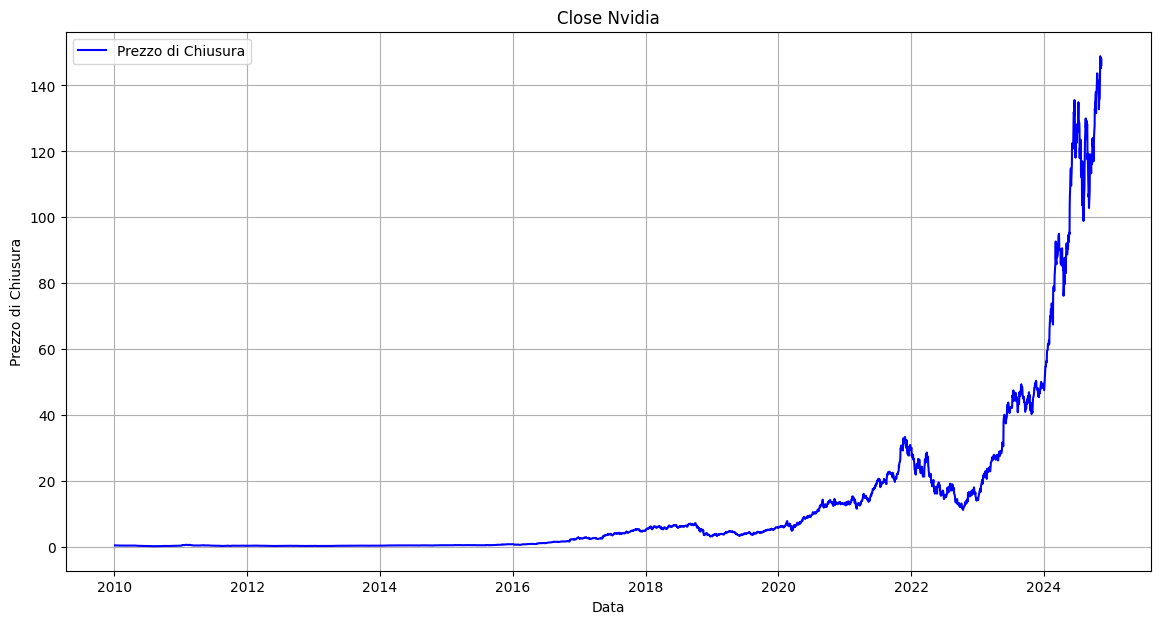

In [58]:
# Filtrare i dati per il simbolo 'NVDA'
nvda_data = data[data['Symbol'] == 'NVDA']

# Convertire la colonna 'Date' in formato datetime
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])

# Ordinare i dati per data
nvda_data = nvda_data.sort_values(by='Date')

# Tracciare il grafico dei prezzi di chiusura
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo di Chiusura', color='blue')
plt.title('Close Nvidia')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.grid(True)
plt.legend()
plt.show()

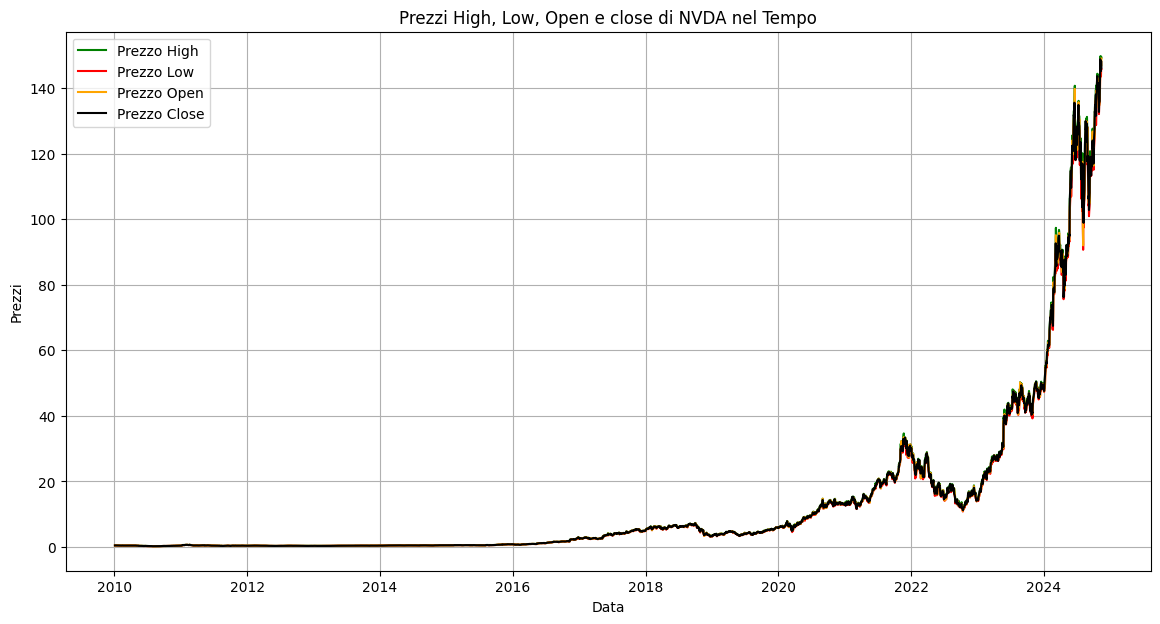

In [43]:
    # Tracciare il grafico dei prezzi di High, Low e Open
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['High'], label='Prezzo High', color='green')
plt.plot(nvda_data['Date'], nvda_data['Low'], label='Prezzo Low', color='red')
plt.plot(nvda_data['Date'], nvda_data['Open'], label='Prezzo Open', color='orange')
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo Close', color='black')
plt.title('Prezzi High, Low, Open e close di NVDA nel Tempo')
plt.xlabel('Data')
plt.ylabel('Prezzi')
plt.grid(True)
plt.legend()
plt.show()

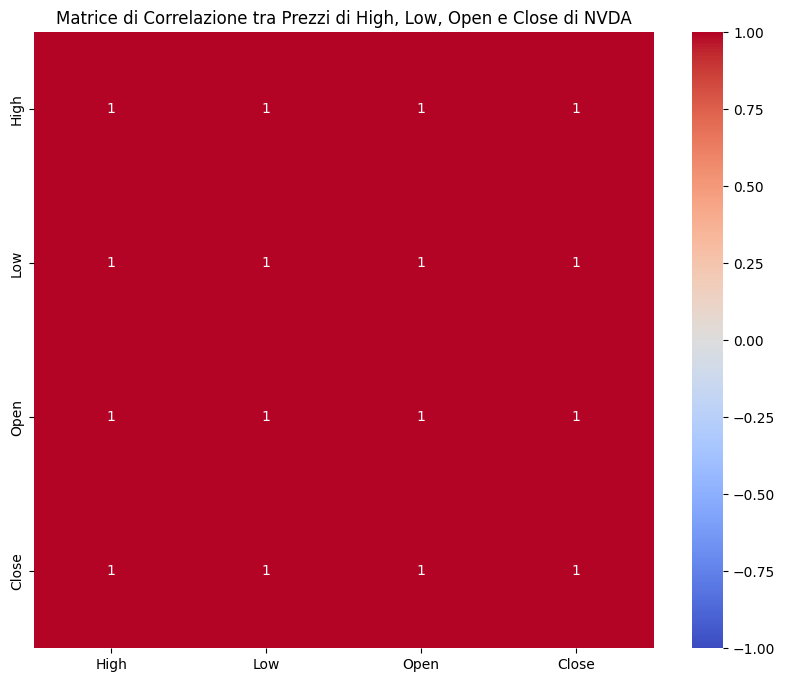

Statistiche descrittive per High, Low, Open e Close:

              High          Low         Open        Close
count  3742.000000  3742.000000  3742.000000  3742.000000
mean     13.176416    12.683224    12.939140    12.941507
std      26.196581    25.193727    25.727914    25.715832
min       0.226250     0.216250     0.218000     0.222000
25%       0.448188     0.433875     0.442313     0.441312
50%       3.490875     3.333375     3.411625     3.423000
75%      13.644625    13.190312    13.446312    13.403937
max     149.770004   146.259995   149.050003   148.880005


In [44]:
# Calcolare la correlazione tra le variabili
correlation_matrix = nvda_data[['High', 'Low', 'Open', 'Close']].corr()

# Visualizzare la matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di Correlazione tra Prezzi di High, Low, Open e Close di NVDA')
plt.show()

# Stampare statistiche descrittive per confrontare i valori
print("Statistiche descrittive per High, Low, Open e Close:\n")
print(nvda_data[['High', 'Low', 'Open', 'Close']].describe())

Visto che le grandezze analizzate sono molto correlate tra di loro con una simile media e std, ci concentriamo sul prezzo di apertura(open) e chiusura(close), cercando di prevedere la differenza open-close, per cosservare quanto è conveniente vendere in quel giorno.

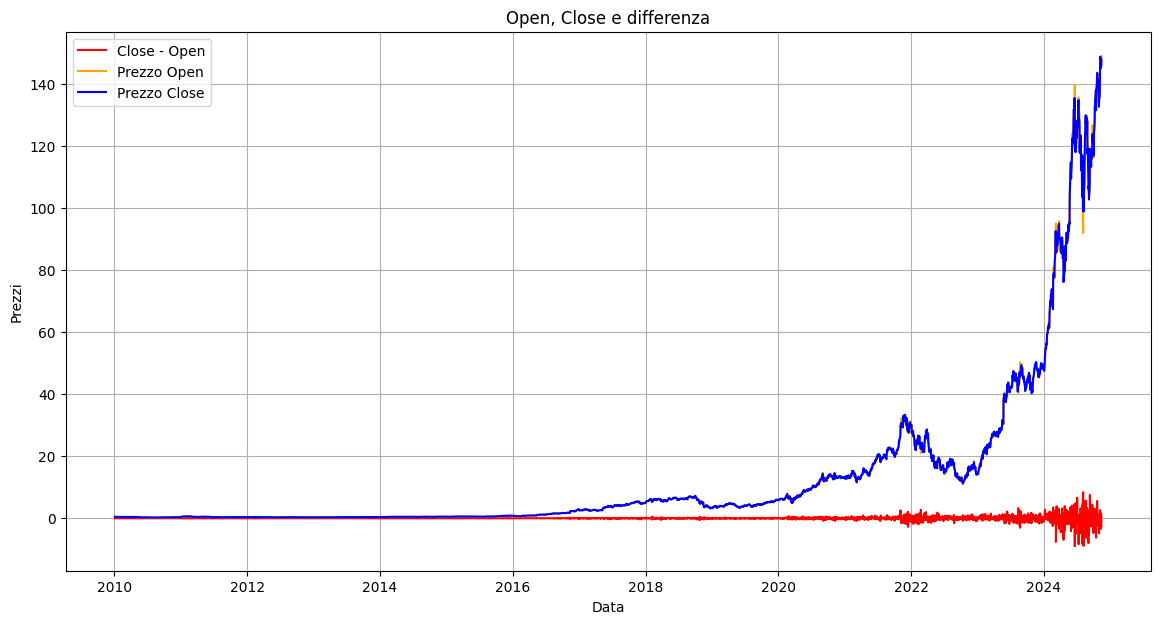

In [45]:
    # Tracciare il grafico dei prezzi di High, Low e Open
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close']-nvda_data['Open'], label='Close - Open', color='red')
plt.plot(nvda_data['Date'], nvda_data['Open'], label='Prezzo Open', color='orange')
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo Close', color='blue')
plt.title('Open, Close e differenza')
plt.xlabel('Data')
plt.ylabel('Prezzi')
plt.grid(True)
plt.legend()
plt.show()

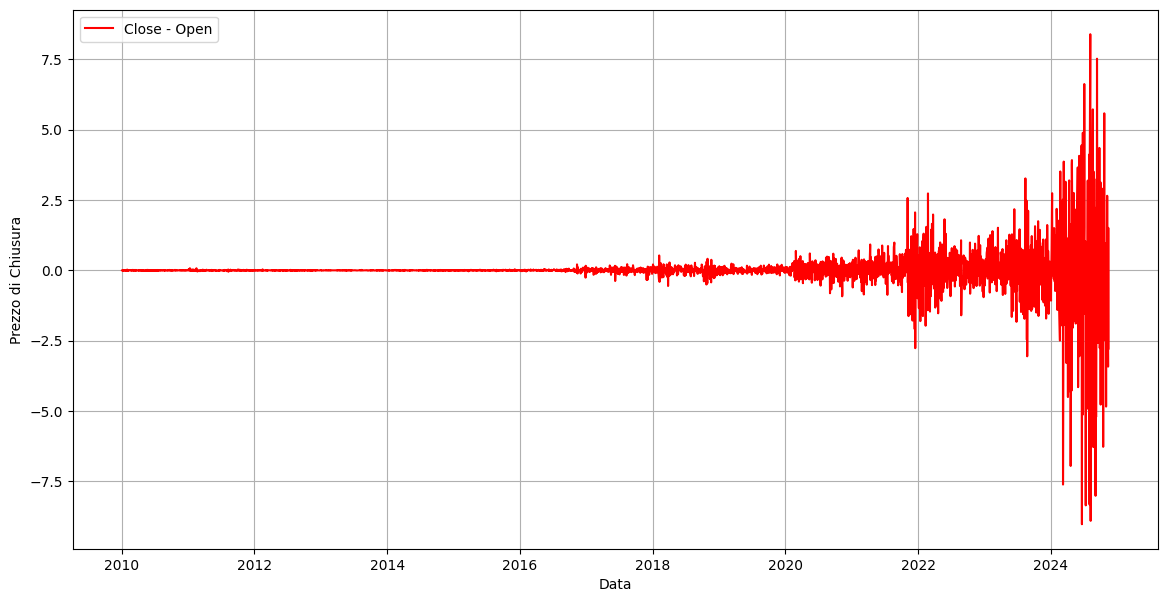

In [46]:
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close']-nvda_data['Open'], label='Close - Open', color='red')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.grid(True)
plt.legend()
plt.show()

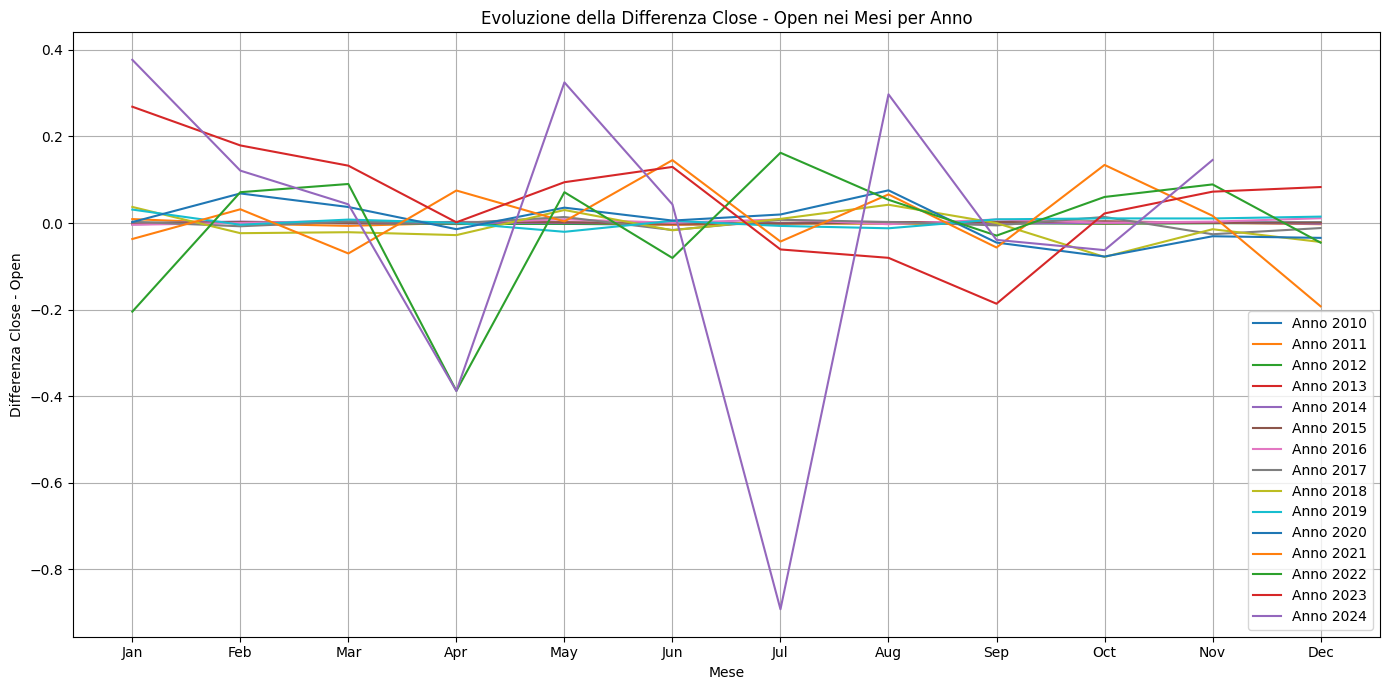

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Assumiamo che 'nvda_data' sia già definito con le colonne 'Date', 'Close', 'Open'

# Assicurati che 'Date' sia nel formato datetime
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])

# Calcolare la differenza Close - Open
nvda_data['Close-Open'] = nvda_data['Close'] - nvda_data['Open']

# Aggiungere colonne per anno e mese
nvda_data['Year'] = nvda_data['Date'].dt.year
nvda_data['Month'] = nvda_data['Date'].dt.month

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Creare il grafico
plt.figure(figsize=(14, 7))

# Per ogni anno, traccia la differenza Close-Open per i mesi
for year in nvda_data['Year'].unique():
    monthly_diff = nvda_data[nvda_data['Year'] == year].groupby('Month')['Close-Open'].mean()
    plt.plot(monthly_diff.index, monthly_diff.values, label=f'Anno {year}')

plt.xlabel('Mese')
plt.ylabel('Differenza Close - Open')
plt.title('Evoluzione della Differenza Close - Open nei Mesi per Anno')
plt.grid(True)
plt.legend()
plt.xticks(range(1, 13), labels=month_names)  # Aggiungi i numeri dei mesi (1-12)
plt.tight_layout()
plt.show()


## Decomposizione STL

In [114]:
# Ordina il DataFrame per la colonna Date
nvda_data = nvda_data.sort_values(by='Date')

# Trova la data di cutoff per gli ultimi 21 giorni
cutoff_date = nvda_data['Date'].max() - pd.Timedelta(days=120)

# Crea il DataFrame train e test
train_data = nvda_data[nvda_data['Date'] <= cutoff_date]
test_data = nvda_data[nvda_data['Date'] > cutoff_date]

# Stampa o verifica i DataFrame
print("Train DataFrame:")
print(train_data.head())

print("\nTest DataFrame:")
print(test_data.head())
print(f"Lughezza test: {len(test_data)}")
print(f"Lughezza train: {len(train_data)}")
print(f"Lunghezza totale: {len(nvda_data)}")


Train DataFrame:
              Date Symbol  Adj Close    Close    High      Low     Open  \
1305958 2010-01-04   NVDA   0.423952  0.46225  0.4655  0.45275  0.46275   
1305959 2010-01-05   NVDA   0.430143  0.46900  0.4740  0.46050  0.46050   
1305960 2010-01-06   NVDA   0.432894  0.47200  0.4730  0.46425  0.46875   
1305961 2010-01-07   NVDA   0.424410  0.46275  0.4715  0.45925  0.46950   
1305962 2010-01-08   NVDA   0.425328  0.46375  0.4670  0.45625  0.45900   

              Volume  Difference  
1305958  800204000.0    -0.00050  
1305959  728648000.0     0.00850  
1305960  649168000.0     0.00325  
1305961  547792000.0    -0.00675  
1305962  478168000.0     0.00475  

Test DataFrame:
              Date Symbol   Adj Close       Close        High         Low  \
1309615 2024-07-17   NVDA  117.979904  117.989998  121.849998  116.720001   
1309616 2024-07-18   NVDA  121.079636  121.089996  122.400002  116.559998   
1309617 2024-07-19   NVDA  117.919914  117.930000  121.599998  117.370003 

In [115]:
import copy


train_data['Difference'] = train_data['Close'] - train_data['Open']
train_data.head()


nvda_data_copy = copy.deepcopy(train_data)
# Verifica che la colonna 'data' sia in formato datetime
nvda_data_copy['Date'] = pd.to_datetime(nvda_data['Date'])

# Imposta la colonna 'data' come indice del DataFrame
nvda_data_copy.set_index('Date', inplace=True)

C:\Users\lucab\AppData\Local\Temp\ipykernel_18384\4286710890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Difference'] = train_data['Close'] - train_data['Open']


Scomposizione in season, trend e residui della stagionalita 

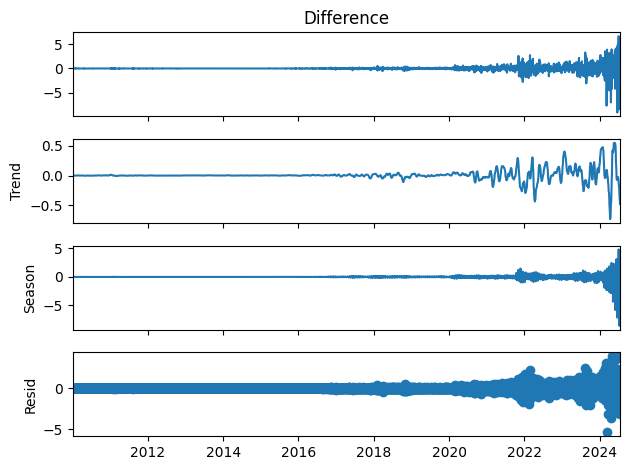

In [154]:
# Esegui la decomposizione STL
stl = STL(nvda_data_copy['Difference'], period=14)  # Modifica la stagionalità a seconda dei tuoi dati
result = stl.fit()

res = stl.fit()
fig = res.plot()



Grafico ACF e PACF della stagionalità

<Figure size 1000x600 with 0 Axes>

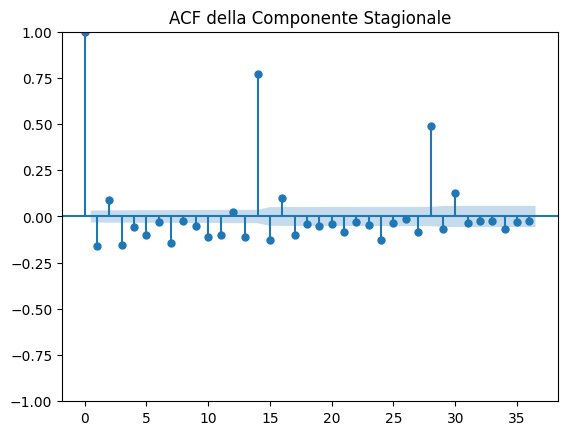

<Figure size 1000x600 with 0 Axes>

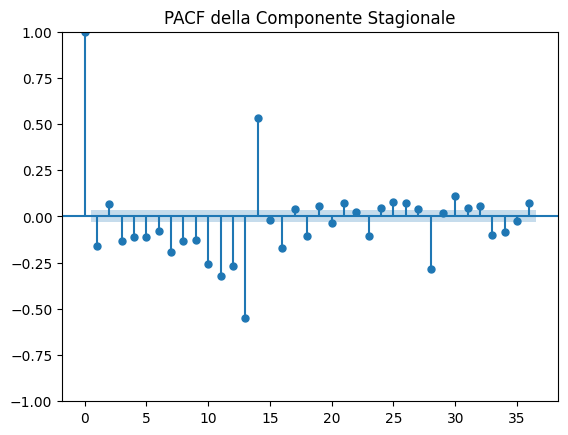

In [ ]:
# Estrai la componente stagionale dalla decomposizione


seasonal_component = result.seasonal

# Plot ACF della componente stagionale
plt.figure(figsize=(10, 6))
plot_acf(seasonal_component)
plt.title("ACF della Componente Stagionale")
plt.show()

# Plot PACF della componente stagionale
plt.figure(figsize=(10, 6))
plot_pacf(seasonal_component)
plt.title("PACF della Componente Stagionale")
plt.show()

## Stationarity

In [157]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value']
    df_test = adfuller(ts)
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])

In [160]:
test_stationarity(train_data['Difference'])

ADF statistic: -11.046598924474509
P-value: 5.204330654174886e-20


## ACF and PACF graph

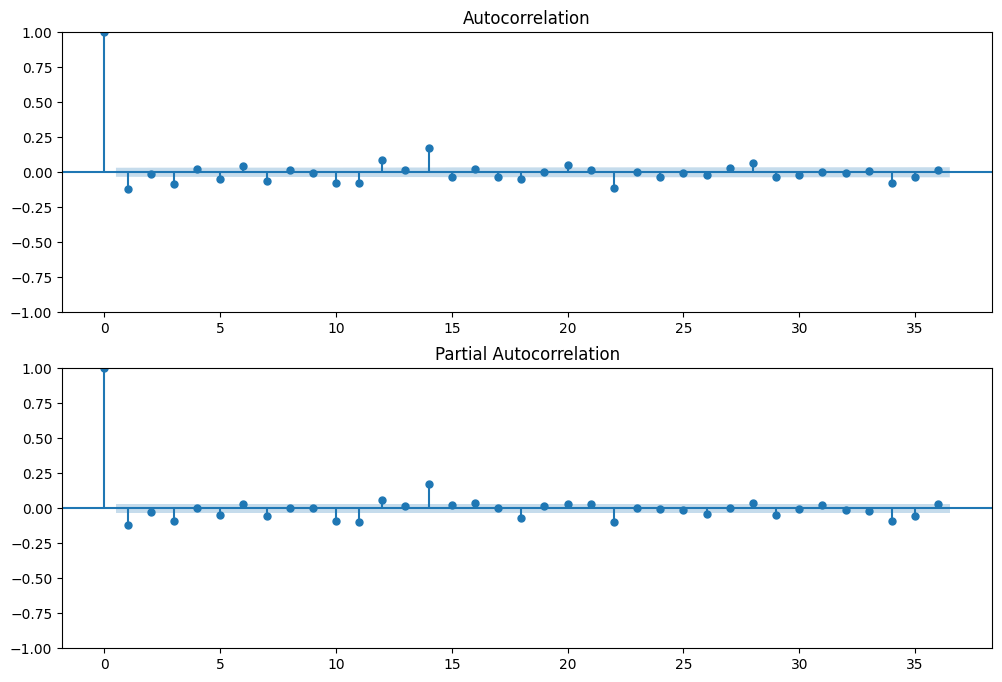

In [141]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['Difference'],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['Difference'], ax=ax2)

# Fitting model

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
model = auto_arima(train_data['Difference'], seasonal=False, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6090.602, Time=1.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6200.551, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6148.219, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6144.351, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6125.091, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6124.645, Time=0.49 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6091.053, Time=1.26 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6090.987, Time=1.60 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6125.780, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6099.698, Time=1.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6105.186, Time=1.12 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=6.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6091.676, Time=1.97 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 16.649 seconds
                          

In [122]:
model = ARIMA(train_data['Difference'], order=(1,0,3))
results = model.fit()

print(results.summary())

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Difference   No. Observations:                 3657
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -3044.532
Date:                Sat, 16 Nov 2024   AIC                           6101.064
Time:                        16:47:09   BIC                           6138.290
Sample:                             0   HQIC                          6114.320
                               - 3657                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.008      0.748      0.455      -0.010       0.021
ar.L1         -0.9299      0.008   -117.192      0.000      -0.945      -0.914
ma.L1          0.8068      0.009     89.624      0.0

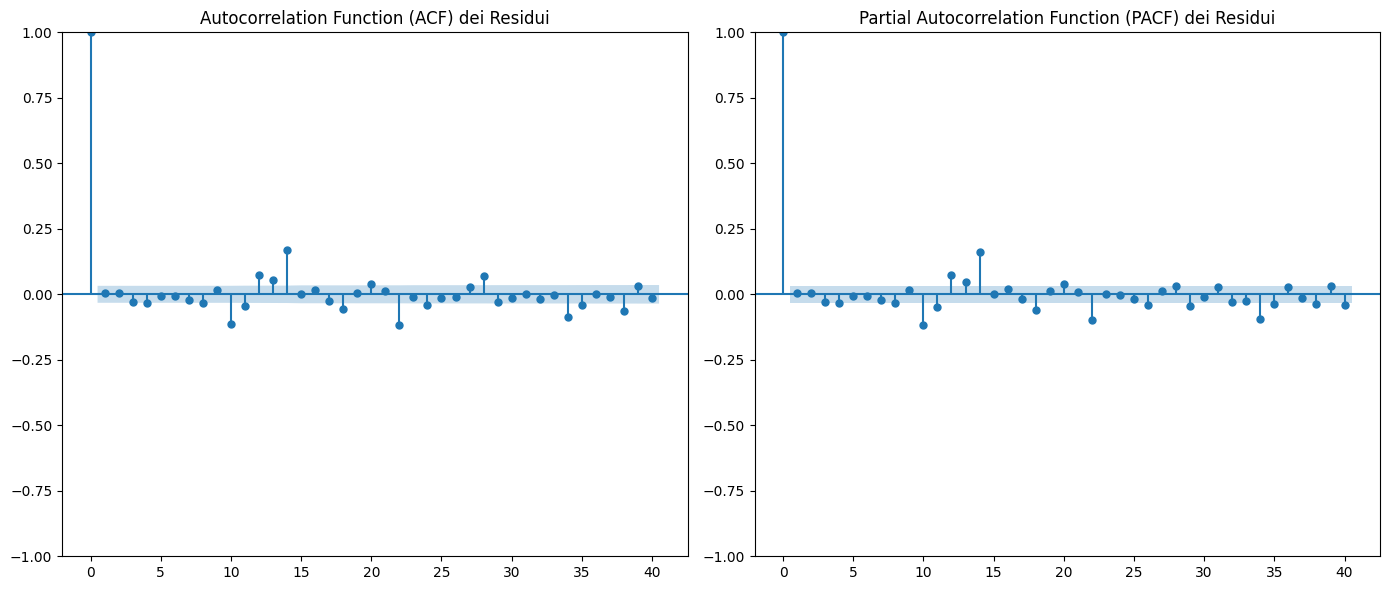

In [123]:
# Previsione dei residui
residuals = results.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

In [ ]:
from pmdarima import auto_arima

# Eseguiamo il modello auto_arima su una serie temporale
model = auto_arima(train_data['Difference'], 
                   seasonal=True,        # Abilitare la stagionalità
                   stepwise=True,        # Ricerca stepwise per migliorare la velocità
                   trace=True,
                   m = 14)

# Ottieni il modello migliore trovato
print(model.summary())

In [166]:
# Modello ARIMA
model = sm.tsa.SARIMAX(train_data['Difference'],
                       order=(3,0,3),           # Parametri ARIMA
                       seasonal_order=(15,0,15,14), # Parametri stagionali (P, D, Q, periodo stagionale S),
                       trend='c')                  # Se includere o meno l'intercetta (opzionale)

results_base = model.fit()

# Sommario del modello
print(results_base.summary())

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


KeyboardInterrupt: 

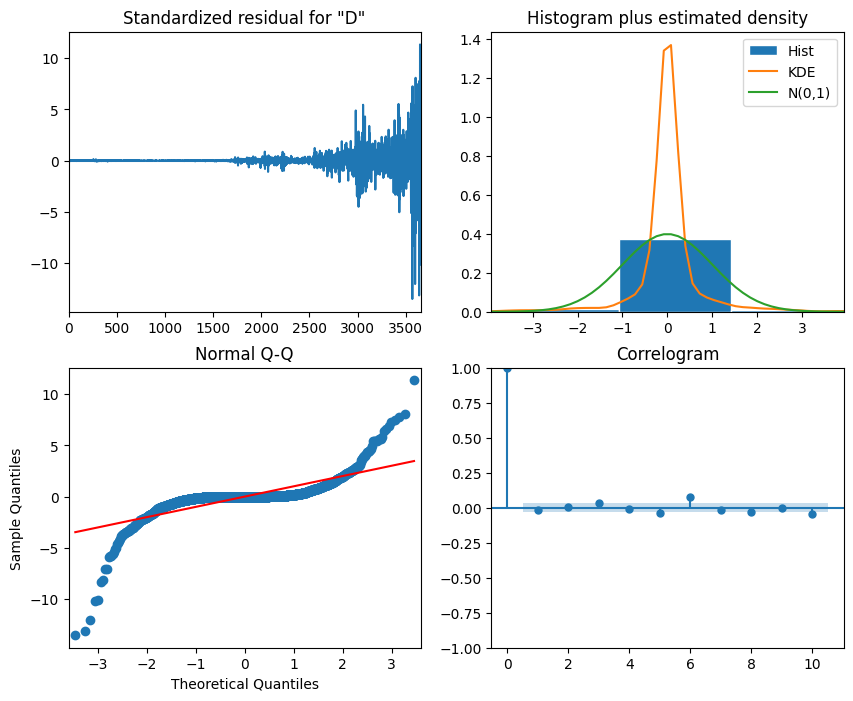

In [165]:
results_base.plot_diagnostics(figsize=(10, 8))
plt.show()